# International Tourist Visits to Bali
## Preface

Bali is the most popular tourist destionation in Indonesia. Every year, foreign visitors flock to the "Island of Gods". Excluding the COVID-19 lockdown between 2020-2022, the number of tourists keep growing. This brought both blessing and curse.

Tourism has been the primary drive of Bali's economy since 1970s. The growing number of tourists influenced the increase of development and service industries. In turns, increased local revenue and government tax.

Lately, tourism has become a problem. The tourists seem to overflowed the island, causing overtourism. Uncontrolled development that follows caused ecological problems. Not to mention the unruly tourists brought social discontent.



## Problems
* What time of the year can we expect the number of tourists grow up?
* What time of the year can we expect the number of tourists go down?
* How much tourists can we expect will come to Bali in the next 2 years?

## Data Loading 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("Banyaknya Wisatawan Mancanegara Bulanan ke Bali Menurut Pintu Masuk, 2013-2025.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Period              156 non-null    object
 1   Month               156 non-null    int64 
 2   Year                156 non-null    int64 
 3   Ngurah Rai Airport  156 non-null    int64 
 4   Seaport             156 non-null    int64 
 5   Total               156 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 7.4+ KB


We will only use two columns for these analysis, the period column and total column. Period column signify more compact time metric, featuring both month and year. Total features the sum of tourist entering both from airport and seaports. Next, we will separate our dataset to train and test part. Train data from before COVID, test data after COVID. Then, we will create a model using the train data and use that model to predict the number of tourist coming after COVID. We will compare it to Data after COVID. If the model we create accurate, we will use it to predict tourist visit for 2026 and 2027

In [72]:
df1 = df.set_index("Period").drop(columns=df.columns[[1,2,3,4]].tolist())
df1.index = pd.to_datetime(df1.index, format="%Y-%m")


df_train = df1.loc[df1.index<"2020-01"]
df_test = df1.loc[df1.index>"2022-12"]

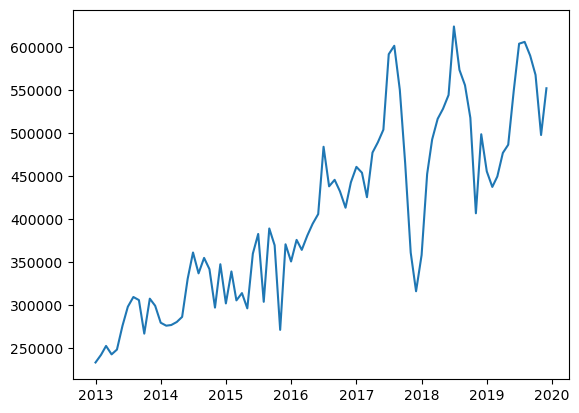

In [73]:
plt.plot(df_train)

From the chart above, we can see that see that the number of tourists keep growing between 2013-2020.

## Seasonality

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose

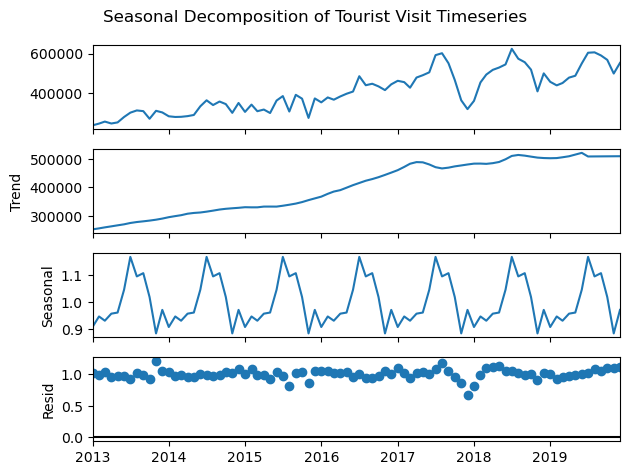

In [89]:
result = seasonal_decompose(
    df_train, model='multiplicative', extrapolate_trend='freq')
result.plot()
plt.suptitle("Seasonal Decomposition of Tourist Visit Timeseries")
plt.tight_layout()
plt.show()

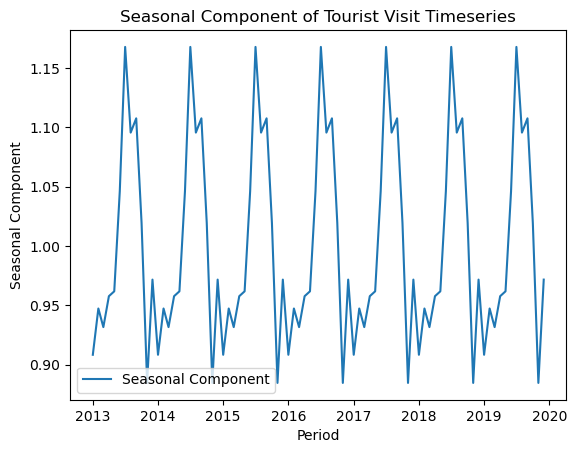

In [90]:
plt.plot(result.seasonal, label="Seasonal Component")
plt.title("Seasonal Component of Tourist Visit Timeseries")
plt.xlabel("Period")
plt.ylabel("Seasonal Component")
plt.legend()
plt.show()

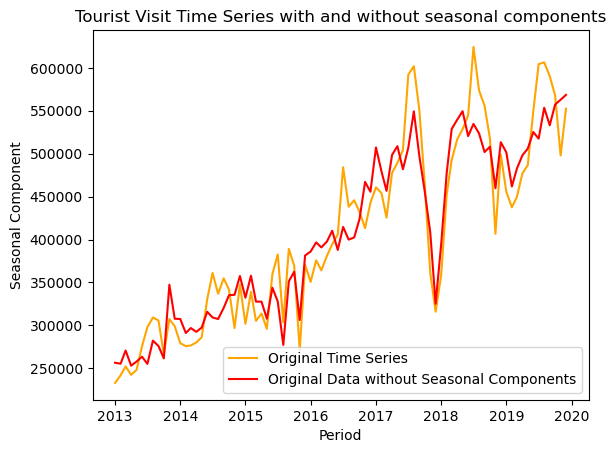

In [95]:
no_seasonal = df_train["Total"]/result.seasonal

plt.plot(df_train, label="Original Time Series",color='orange')
plt.plot(no_seasonal, label="Original Data without Seasonal Components",color='red')
plt.title("Tourist Visit Time Series with and without seasonal components")
plt.xlabel("Period")
plt.ylabel("Seasonal Component")
plt.legend()
plt.show()

## Stationarity

In [99]:
values = no_seasonal

parts = int(len(values)/3)

part_1, part_2, part_3 = values[0:parts], values[parts:(parts*2)], values[(parts*2):(parts*3)]

mean_1, mean_2, mean_3 = part_1.mean(), part_2.mean(), part_3.mean()

var_1, var_2, var_3 = part_1.var(), part_2.var(), part_3.var()

print(f"mean_1={mean_1}, mean_2={mean_2}, mean_3={mean_3}")
print(f"var_1={var_1}, var_2={var_2}, var_3={var_3}")

mean_1=299927.636427466, mean_2=413545.52784240077, mean_3=500197.9616351578
var_1=1092131778.5054984, var_2=4879054881.861546, var_3=2969126844.795057


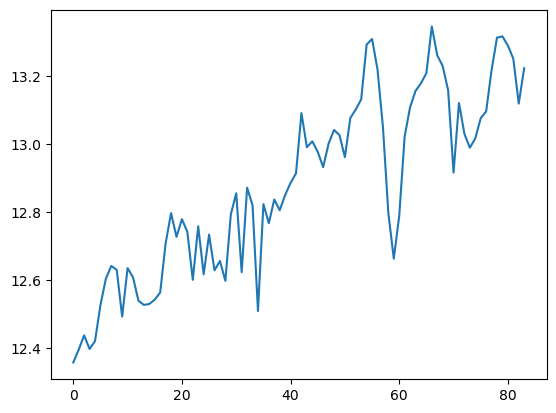

In [100]:
values = np.log(df_train.values)

plt.plot(values)

In [101]:
parts = int(len(values)/3)

part_1, part_2, part_3 = values[0:parts], values[parts:(parts*2)], values[(parts*2):(parts*3)]

mean_1, mean_2, mean_3 = part_1.mean(), part_2.mean(), part_3.mean()

var_1, var_2, var_3 = part_1.var(), part_2.var(), part_3.var()

print(f"mean_1={mean_1}, mean_2={mean_2}, mean_3={mean_3}")
print(f"var_1={var_1}, var_2={var_2}, var_3={var_3}")

mean_1=12.593037997787167, mean_2=12.924418325962293, mean_3=13.112189815188247
var_1=0.014373232201371657, var_2=0.03285226406005378, var_3=0.027203128999229585


In [108]:
from statsmodels.tsa.stattools import adfuller

res = adfuller(no_seasonal)

print(f"ADF Statistics: {res[0]}")
print(f"p-value: {res[1]}")

print("Critical values at different levels:")
for k, v in res[4].items():
    print(f"{k}: {v}")

if res[1] < 0.05 : print("Data is stationary (p-value < 0.05)")
else : print("Data is not stationary (p-value >= 0.05)")

ADF Statistics: -1.423126575855868
p-value: 0.5711401126128558
Critical values at different levels:
1%: -3.5117123057187376
5%: -2.8970475206326833
10%: -2.5857126912469153
Data is not stationary (p-value >= 0.05)


We will try differencing to prepare the data for forecasting

In [110]:
data_diff = no_seasonal.diff().dropna()
res = adfuller(data_diff)

print(f"ADF Statistics: {res[0]}")
print(f"p-value: {res[1]}")

print("Critical values at different levels:")
for k, v in res[4].items():
    print(f"{k}: {v}")

if res[1] < 0.05 : print("Data is stationary (p-value < 0.05)")
else : print("Data is not stationary (p-value >= 0.05)")

ADF Statistics: -5.914498119661318
p-value: 2.591982727592715e-07
Critical values at different levels:
1%: -3.517113604831504
5%: -2.8993754262546574
10%: -2.5869547797501644
Data is stationary (p-value < 0.05)


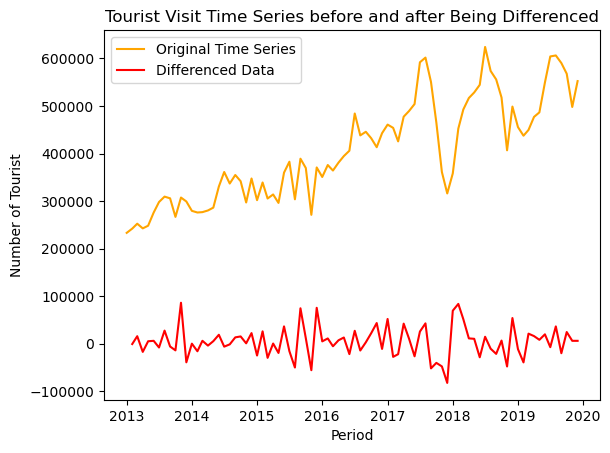

In [111]:
plt.plot(df_train, label="Original Time Series",color='orange')
plt.plot(data_diff, label="Differenced Data",color='red')
plt.title("Tourist Visit Time Series before and after Being Differenced")
plt.xlabel("Period")
plt.ylabel("Number of Tourist")
plt.legend()
plt.show()

## Forecasting

we will be using SARIMA to forecast the future visit

In [133]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

<Axes: xlabel='Period'>

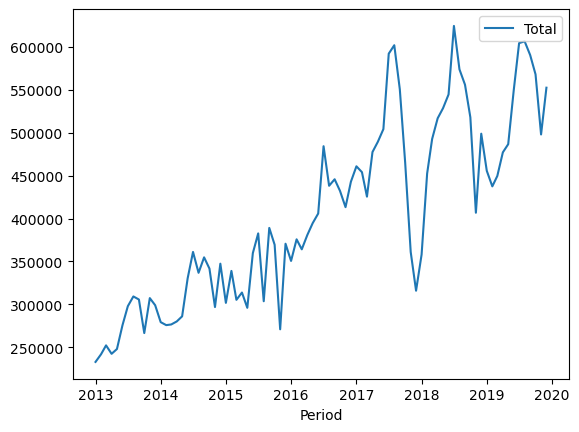

In [114]:
sns.lineplot(df_train)

<Axes: xlabel='Period'>

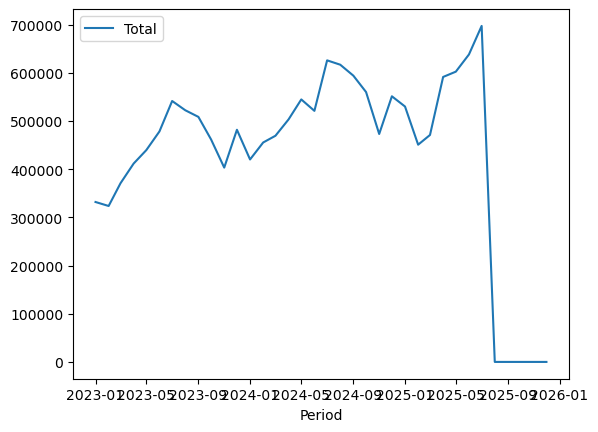

In [115]:
sns.lineplot(df_test)

### Combined Approach

In [162]:
df_exe = pd.concat([df_train, df_test]).reset_index().loc[:114]
# df_exe = pd.concat([df_train, df_test]).reset_index().loc[:114].set_index("Period")

<Axes: >

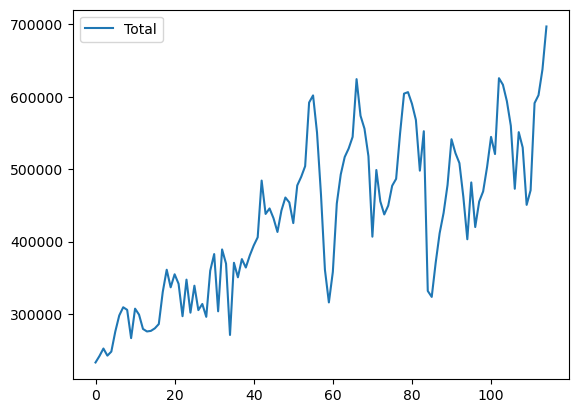

In [163]:
sns.lineplot(df_exe)

In [164]:
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')

In [165]:
check_stationarity(df_exe["Total"].diff().dropna())

ADF Statistic: -4.096422257563425
p-value: 0.0009817971941100566
Stationary


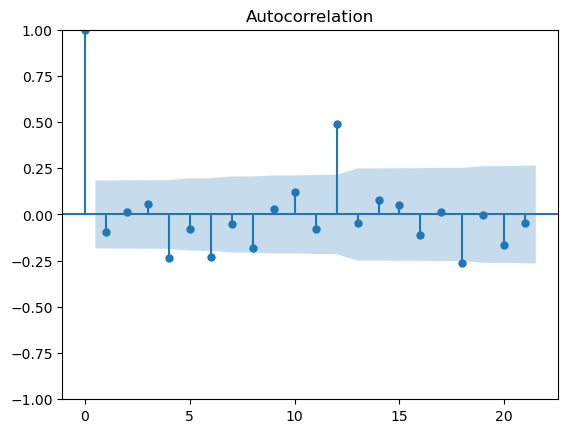

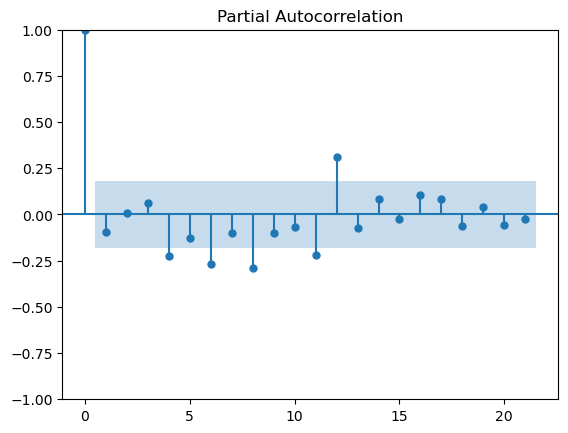

In [166]:
diffed_exe = df_exe["Total"].diff().dropna()

plot_acf(diffed_exe)
plot_pacf(diffed_exe)
plt.show()

In [167]:
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12

model = SARIMAX(diffed_exe, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

C:\Users\hatta\anaconda3\envs\txt_processing\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\hatta\anaconda3\envs\txt_processing\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [168]:
forecast_periods = 24
forecast = results.forecast(steps = forecast_periods)

C:\Users\hatta\anaconda3\envs\txt_processing\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hatta\anaconda3\envs\txt_processing\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


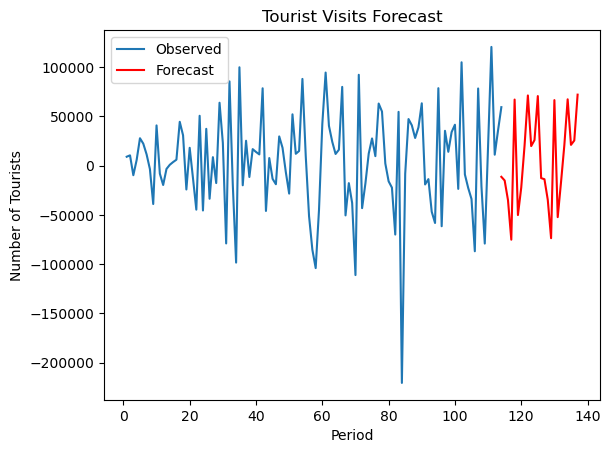

In [171]:
plt.plot(diffed_exe, label='Observed')
plt.plot(forecast, label='Forecast', color='red')
plt.title("Tourist Visits Forecast")
plt.xlabel("Period")
plt.ylabel("Number of Tourists")
plt.legend()
plt.show()

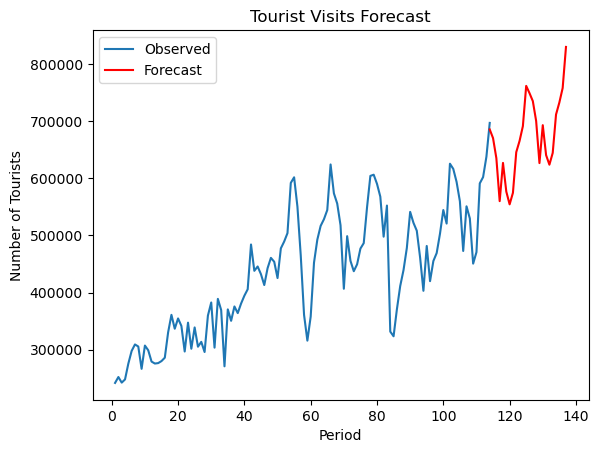

In [193]:
recon_exe = diffed_exe.cumsum() + df_exe["Total"][0]
recon_forecast = forecast.cumsum() + df_exe["Total"][114]

plt.plot(recon_exe, label='Observed')
plt.plot(recon_forecast.astype(int), label='Forecast', color='red')
plt.title("Tourist Visits Forecast")
plt.xlabel("Period")
plt.ylabel("Number of Tourists")
plt.legend()
plt.show()

In [192]:
recon_forecast.astype(int)

114    685660
115    670473
116    635373
117    560126
118    627072
119    576826
120    554514
121    574737
122    645860
123    665603
124    691442
125    761928
126    749174
127    735265
128    700499
129    626746
130    693141
131    640766
132    623951
133    644628
134    711828
135    732797
136    758212
137    830145
Name: predicted_mean, dtype: int64

### Separated Approach